### Link to the dataset: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification

In [1]:
from google.colab import files

# Upload the Kaggle API key file (kaggle.json) that you downloaded from Kaggle
uploaded = files.upload()

# Move the uploaded API key to the required directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!pip install kaggle

In [3]:
!kaggle datasets download -d asdasdasasdas/garbage-classification

 79% 65.0M/82.0M [00:00<00:00, 147MB/s]
100% 82.0M/82.0M [00:00<00:00, 149MB/s]


In [ ]:
!unzip garbage-classification.zip

In [ ]:
!pip install rembg

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import pickle

import cv2
# from rembg import remove
from PIL import Image
from IPython.display import display

import os
import shutil
from shutil import copyfile

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Functions

## Split data

In [9]:
def create_train_valid_test_dirs(root_path, subdir_names, train_valid_test_names=['train', 'valid', 'test']):
    """ Function for creating separate folders that contain data for training, validation and testing of the model
    Args:
        1) root_path - the path to the parent folder in which you want to create subfolders
        2) subdir_names - a list of label class names (subfolders with the specified names will be created in each of the train, valid, and test folders)
        3) train_valid_test_names - a list of names of training, validation and test samples
    Returns:
        None; but creates folders
    """
    parent_directories = []
    for dir_name in train_valid_test_names:
        parent_directories.append(os.path.join(root_path, dir_name))

    for directory in parent_directories:
        if not os.path.exists(directory):
            os.makedirs(directory)
        for subdirectory in subdir_names:
            subdir_name = os.path.join(directory + '/', subdirectory)
            if not os.path.exists(subdir_name):
                os.makedirs(subdir_name)

In [10]:
def split_data(source_dir_path, train_dir_path, valid_dir_path, test_dir_path, train_test_split=0.8, train_valid_split=0.85, random_sample=True):
    """ Function to split the files of the specified folder into training, validation and test samples by copying
    the files from source_dir_path to the corresponding folders
    Args:
        1) source_dir_path - the path to the folder containing the original data to be split into train/valid/test
        2) train_dir_path - the path to the folder that will contain the training data
        3) valid_dir_path - the path to the folder that will contain the validation data
        4) test_dir_path - the path to the folder that will contain the test data
        5) train_test_split - the ratio between training and test samples ([0; 1])
        6) train_valid_split - the ratio between training and validation samples ([0; 1])
        7) random_sample - whether files need to be shuffled randomly before splitting into training, validation, and test samples
    Returns:
        None, but split the files into training, validation and test samples
    """
    fnames = os.listdir(source_dir_path)

    processed_fnames = []
    for file_name in fnames:
        if os.path.getsize(os.path.join(source_dir_path, file_name)) > 0:
            processed_fnames.append(file_name)
        else:
            print(f'{file_name} is zero length, so ignoring.')

    if random_sample:
        processed_fnames = random.sample(processed_fnames, len(processed_fnames))

    split_index = int(train_test_split * len(processed_fnames))
    train_valid_files = processed_fnames[:split_index]
    test_files = processed_fnames[split_index:]

    split_index = int(train_valid_split * len(train_valid_files))
    train_files = train_valid_files[:split_index]
    valid_files = train_valid_files[split_index:]

    # Copy training files
    for file in train_files:
        source = os.path.join(source_dir_path, file)
        destination = os.path.join(train_dir_path, file)
        copyfile(source, destination)

    # Copy validation files
    for file in valid_files:
        source = os.path.join(source_dir_path, file)
        destination = os.path.join(valid_dir_path, file)
        copyfile(source, destination)

    # Copy test files
    for file in test_files:
        source = os.path.join(source_dir_path, file)
        destination = os.path.join(test_dir_path, file)
        copyfile(source, destination)


In [11]:
def split_class_data(source_dir_path, train_valid_test_paths, class_dir_name, train_test_split=0.8, train_valid_split=0.85, random_sample=True):
    """ Function for dividing the data of one label class into train/valid/test
    Args:
        1) source_dir_path - the path to the folder containing the original data of all label classes which needs to be splitted into train/valid/test;
        2) train_valid_test_paths - the list of paths to the folders of training, validation and test samples
        (the paths are specified in this order: train, valid, test)
        3) class_dir_name - the name of the folder that contains the label class data
        4) train_test_split - the ratio between training and test samples ([0; 1])
        5) train_valid_split - the ratio between training and validation samples ([0; 1])
        6) random_sample - whether files need to be shuffled randomly before splitting into training, validation, and test samples
    Returns:
        None, but split the files of label class into training, validation and test samples
    """
    train_dir_path_class = os.path.join(train_valid_test_paths[0], class_dir_name)
    valid_dir_path_class = os.path.join(train_valid_test_paths[1], class_dir_name)
    test_dir_path_class = os.path.join(train_valid_test_paths[2], class_dir_name)
    source_dir_path_class = os.path.join(source_dir_path, class_dir_name)
    split_data(source_dir_path=source_dir_path_class, train_dir_path=train_dir_path_class, valid_dir_path=valid_dir_path_class,
               test_dir_path=test_dir_path_class,
               train_test_split=train_test_split, train_valid_split=train_valid_split, random_sample=random_sample)

## Display images

In [12]:
def display_image(img, title=None):
    """ Function to display an image
    Args:
        1) img - image object
        2) title - the title that will be displayed above the image
    Returns:
        None; but displays an image
    """
    plt.imshow(img)
    plt.title(title)
    plt.show()

In [13]:
def display_original_augmented_img(original_img, augmented_img, original_title=None, augmented_title=None):
    """ Function to display the original and augmented image on the same graph
    Args:
        1) original_img - object of the original image
        2) augmented_img - augmented image object
        3) original_title - title for the original image
        4) augmented_title - title for the augmented image
    Returns:
        None; but displays images
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_img)
    axes[0].set_title(original_title)

    axes[1].imshow(augmented_img)
    axes[1].set_title(augmented_title)
    plt.show()

## Display data

In [14]:
def load_display_image(root_path, image_name, title=None):
    """ Function to display an image
    Args:
        1) root_path - the path to the folder that contains the image
        2) image_name - the name of the image
        3) title - the title that will be displayed above the image
    Returns:
        None; but displays an image
    """
    img = cv2.imread(os.path.join(root_path, image_name))
    plt.imshow(img)
    plt.title(title)
    plt.show()

In [15]:
def display_pie_chart(df, column_name, title=None, column_contains_count=False, filename=None):
    """ Function to display the percentage ratio of column (with the name column_name) content
    Args:
        1) df - the original dataframe that contains the required information
        2) column_name - the name of the df dataframe column whose percentage values are to be found
        3) title - the title of the graph
        4) column_contains_count - the dataframe column already contains the number of repetitions of the target values (target value count)
        5) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        None, but plots graph
    """
    # Calculate the percentage of each activity in original_df
    if column_contains_count:
        activity_percentages_df = df[column_name] / sum(df[column_name])
    else:
        activity_percentages_df = df[column_name].value_counts(normalize=True) * 100

    plt.figure(figsize=(12, 6))

    # Plot pie chart for df
    sns.set_palette("Set3")
    plt.pie(activity_percentages_df, labels=activity_percentages_df.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)

    # Adjust layout
    plt.tight_layout()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()


def display_pie_charts(first_df, second_df, column, column_contains_count=False, first_chart_title='First DataFrame', second_chart_title='Second DataFrame', filename=None):
    """Function for displaying the ratio of column content between two dataframes in the form of pie charts
    Args:
        1) first_df - the original dataframe that contains the required information
        2) second_df - a dataframe that contains the results of windowing
        3) column - the name of the dataframe column whose percentage values are to be found
        4) column_contains_count - the dataframe column already contains the number of repetitions of the target values (target value count)
        5) first_chart_title - the title for the first pie chart
        6) second_chart_title - the title for the second pie chart
        7) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        None; just builds a pie chart to display the ratio of column contents between two dataframes
    """
    # Calculate the percentage of each activity in first_df
    if column_contains_count:
        activity_percentages_first_df = first_df[column] / sum(first_df[column]) * 100
    else:
        activity_percentages_first_df = first_df[column].value_counts(normalize=True) * 100

    # Calculate the percentage of each activity in second_df
    if column_contains_count:
        activity_percentages_second_df = second_df[column] / sum(second_df[column]) * 100
    else:
        activity_percentages_second_df = second_df[column].value_counts(normalize=True) * 100

    # Create subplots for pie charts
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot pie chart for df
    sns.set_palette("Set3")
    axes[0].pie(activity_percentages_first_df, labels=activity_percentages_first_df.index, autopct='%1.1f%%', startangle=140)
    axes[0].set_title(first_chart_title)

    # Plot pie chart for windowed_df
    sns.set_palette("Set3")
    axes[1].pie(activity_percentages_second_df, labels=activity_percentages_first_df.index, autopct='%1.1f%%', startangle=140)
    axes[1].set_title(second_chart_title)

    # Adjust layout
    plt.tight_layout()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()

## Perform image augmentation using ImageDataGenerator

In [37]:
def get_ImageDataGen_image(imageDataGenerator, image):
  """ Function that returns an image augmented with imageDataGenerator
  Args:
    1) imageDataGenerator - an object of type ImageDataGenerator
    2) image - an image passed as a numpy array
  Returns:
    augmented_image
  """
  x = image.copy()
  x = np.expand_dims(x, axis=0)

  for batch in imageDataGenerator.flow(x, batch_size=1):
      augmented_image=batch[0].copy().astype(np.uint8)
      break

  return augmented_image

In [16]:
def perform_ImageDataGen_augmentation(imageDataGenerator, images, image_filenames, target_size,
                                      augm_prefix, num_augm_images=3, augm_images_dir_path=None,
                                      save_augm_image=True, display_orig_augm_images=False):
    """ Function to create augmented images from images using imageDataGenerator
    Args:
        1) imageDataGenerator - ImageDataGenerator class object
        2) images - a list of images, each of which is stored as a numpy array
        3) image_filenames - a list of image file names images (the names are used in the headers of the images that will be saved)
        4) target_size - the size of the images
        5) augm_prefix - prefix to be added to the beginning of the file name to indicate the augmentation technique
        6) num_augm_images - the number of instances of augmented images for one original
        7) augm_images_dir_path - the path to the folder where you want to save the augmented images (used if save_augm_image=True)
        8) save_augm_image - whether to save the augmented image
        9) display_orig_augm_images - whether to display the original and augmented image at the same time (original - left, augmented - right)
    Returns:
        None; but saves or displays augmented_images
    """
    augmented_index = 0
    for (image_name, img) in zip(image_filenames, images):
        x = img.copy()
        x = np.expand_dims(x, axis=0)

        i = 0
        for batch in datagen.flow(x, batch_size=1):
            i += 1
            if i > num_augm_images:
                augmented_index = 0
                break

            augmented_image_name = f"{augm_prefix}_{image_name.split('.')[0]}_{augmented_index}.jpg"

            augmented_index += 1

            if save_augm_image and (augm_images_dir_path is not None):
                os.makedirs(augmented_images_dir, exist_ok=True)
                augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
                # tf.keras.preprocessing.image.save_img(augmented_image_path, batch[0])
                cv2.imwrite(augmented_image_path, cv2.cvtColor(batch[0].copy().astype(np.uint8), cv2.COLOR_BGR2RGB))
            if display_orig_augm_images:
                display_original_augmented_img(original_img=img, augmented_img=batch[0].copy().astype(np.uint8),
                                               original_title=f"Original_image: {image_name}",
                                               augmented_title=f"{augm_prefix}: {image_name}")

## Perform image augmentation using CV2

### Augmentation functions

In [17]:
def get_width_shift_image(image, width_shift_fraction):
    """ Function for performing width_shift augmentation over the image 'image'
    Args:
        1) image - image object
        2) width_shift_fraction - offset value ([-1; 1])
    Returns:
        augmented_image
    """
    # Get the height and width of the image
    height, width = image.shape[:2]

    # Calculate the height shift value
    width_shift = int(height * width_shift_fraction)

    # Calculate the new y-coordinate for height shift
    y_shifted = height // 2 + width_shift

    # Calculate the rotation matrix for height shift
    shift_matrix = np.float32([[1, 0, 0], [0, 1, width_shift]])

    # Apply the height shift to the image using warpAffine
    changed_image = cv2.warpAffine(image, shift_matrix, (width, height))
    return changed_image

In [18]:
def get_height_shift_image(image, height_shift_fraction):
    """ Function for performing height_shift augmentation over the image 'image'
    Args:
        1) image - image object
        2) height_shift_fraction - offset value ([-1; 1])
    Returns:
        augmented_image
    """
    # Get the height and width of the image
    height, width = image.shape[:2]

    # Calculate the height shift value
    height_shift = int(width * height_shift_fraction)

    # Calculate the new x-coordinate for height shift
    x_shifted = width // 2 + height_shift

    # Calculate the rotation matrix for height shift
    shift_matrix = np.float32([[1, 0, height_shift], [0, 1, 0]])

    # Apply the height shift to the image using warpAffine
    changed_image = cv2.warpAffine(image, shift_matrix, (width, height))
    return changed_image

In [19]:
def get_brightness_augmentation_image(image, brightness_range=(0.5, 1.5)):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Generate a random brightness factor within the specified range
    brightness_factor = np.random.uniform(brightness_range[0], brightness_range[1])

    # Adjust the brightness by scaling the V channel
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * brightness_factor, 0, 255)

    # Convert the image back to the original color space (BGR)
    augmented_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return augmented_image

In [20]:
def get_contrast_augmentation_image(image, contrast_factor):
    """ Function for performing height_shift augmentation over the image 'image'
    Args:
        1) image - image object
        2) contrast_factor - adjusts the contrast of the image by applying CLAHE; possible values: [1.0; 4.0]
    Returns:
        augmented_image
    """
    # Convert the image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image into L, A, and B channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L channel
    clahe = cv2.createCLAHE(clipLimit=contrast_factor, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge the CLAHE enhanced L channel with the original A and B channels
    limg = cv2.merge((cl, a, b))

    # Convert the LAB image back to BGR color space
    contrast_augmented_image = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return contrast_augmented_image

In [21]:
def get_hsv_image(image, hue_shift, saturation_scale=1, value_scale=1):
    """ Function to change the color tone of the image when switching to the HSV model
    Args:
        1) image - image object
        2) hue_shift - the value of the Hue parameter of the hsv model; possible values: [0; 179] (OpenCV)
        3) saturation_scale - coefficient by which the Saturation parameter of the HSV model will be multiplied
        4) value_scale - coefficient by which the Value parameter of the HSV model will be multiplied
    Returns:
        augmented_image
    """
    # Convert the original image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Apply the hue shift to the hue channel
    hsv_image[:, :, 0] = (hsv_image[:, :, 0] + hue_shift) % 180
    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * saturation_scale, 0, 255)
    hsv_image[:, :, 2] = np.clip(hsv_image[:, :, 2] * value_scale, 0, 255)

    # Convert the image back to the RGB color space
    augmented_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return augmented_image

In [36]:
def get_noisy_image(image, mean=1, std_dev=0.7):
    """ Function for adding random noise to the image 'image'
    Args:
        1) image - an image passed as a numpy array
        2) mean - the mean value of the noise
        3) std_dev - the standard deviation of the noise (the larger the std_dev, the more intense the noise will be)
    Returns:
        augmented_image
    """
    noise = np.random.normal(mean, std_dev, image.shape).astype('uint8')
    augmented_image = cv2.add(image, noise)

    return augmented_image

In [38]:
def remove_background(input_path, output_path=None):
    """ Function to remove the background from the image
    Args:
      1) input_path - the path to the image whose background should be removed
      2) output_path - the path to save an image without a background
    Returns:
      Image without background
    """
     # Processing the image
    input_image = Image.open(input_path)

    # Removing the background from the given Image
    output_image = remove(input_image)

    # Convert the output image to RGB mode (removing transparency)
    output_image = output_image.convert("RGB")

    if output_path:
      # Save the image with the background removed
      output_image.save(output_path)
    return output_image

In [39]:
def get_background_image(image, background_image, source_path, image_name, no_background_output_path=None):
  """ Function to replace the background of the original image with the background image background_image
  Args:
    1) image - an image passed as a numpy array
    2) background_image - a background image passed as a numpy array
    3) source_path - path to image 'image'
    4) image_name - name of the image 'image'
    5) no_background_output_path - the path (along with the image name) to store the original image without the background
  Returns:
    augmented_image
  """
  if no_background_output_path is not None:
    pil_image = remove_background(input_path=os.path.join(source_path, image_name),
                    output_path=os.path.join(no_background_output_path, image_name))
  else:
    pil_image = remove_background(input_path=os.path.join(source_path, image_name))

  augmented_image = background_image.copy()

  # Convert PIL image to OpenCV format (NumPy array)
  image_without_background = np.array(pil_image)

  mask = cv2.cvtColor(image_without_background, cv2.COLOR_BGR2GRAY)
  _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
  mask_inv = cv2.bitwise_not(mask)

  garbage_area = cv2.bitwise_and(image_without_background, image_without_background, mask=mask)
  background_area = cv2.bitwise_and(augmented_image, augmented_image, mask=mask_inv)
  augmented_image = cv2.add(garbage_area, background_area)

  return augmented_image

In [40]:
def get_augmented_background_image(imageDataGenerator, image, background_image, source_path, image_name):
  """ Function that returns a new augmented image (eg reduced in size) with a new background
  Args:
    1) imageDataGenerator - an object of type ImageDataGenerator
    2) image - an image passed as a numpy array
    3) background_image - a background image passed as a numpy array
    4) source_path -  path to image 'image'
    5) image_name - name of the image 'image'
  Returns:
    augmented_image
  """
  pil_image = remove_background(input_path=os.path.join(source_path, image_name))

  # Convert PIL image to OpenCV format (NumPy array)
  image_without_background = np.array(pil_image)

  changed_image = get_ImageDataGen_image(imageDataGenerator=imageDataGenerator,
                                         image=image_without_background)

  mask = cv2.cvtColor(changed_image, cv2.COLOR_BGR2GRAY)
  _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
  mask_inv = cv2.bitwise_not(mask)

  garbage_area = cv2.bitwise_and(changed_image, changed_image, mask=mask)
  augmented_image = background_image.copy()
  background_area = cv2.bitwise_and(augmented_image, augmented_image,
                                  mask=mask_inv)
  augmented_image = cv2.add(garbage_area, background_area)

  return augmented_image

### Augmentation algorithms

In [22]:
def perform_cv2_rotation_augmentation(rotation_range, images, image_filenames,
                                      target_size, augm_prefix,
                                      num_augm_images=3, augm_images_dir_path=None,
                                      save_augm_image=True, display_orig_augm_images=False):
    """ Function to create augmented images from images using imageDataGenerator
    Args:
        1) rotation_range - the range (a list of two elements: [range_min; range_max]) in which the angle value will change linearly (depending on num_augm_images)
        2) images - a list of images, each of which is stored as a numpy array
        3) image_filenames - a list of image file names images (the names are used in the headers of the images that will be saved)
        4) target_size - the size of the images
        5) augm_prefix - prefix to be added to the beginning of the file name to indicate the augmentation technique
        6) num_augm_images - the number of instances of augmented images for one original
        7) augm_images_dir_path - the path to the folder where you want to save the augmented images (used if save_augm_image=True)
        8) save_augm_image - whether to save the augmented image
        9) display_orig_augm_images - whether to display the original and augmented image at the same time (original - left, augmented - right)
    Returns:
        None; but saves or displays augmented_images
    """
    height = target_size[0]
    width = target_size[1]
    angle_increment = int((rotation_range[1] - rotation_range[0]) / num_augm_images)
    for (image_name, img) in zip(image_filenames, images):
        augmented_index = 0
        angle = rotation_range[0]
        for i in range(num_augm_images):
            # Calculate the rotation matrix
            rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

            # Apply the rotation to the image using warpAffine
            augmented_image = cv2.warpAffine(img, rotation_matrix, (width, height))
            augmented_image_name = f"{augm_prefix}_{image_name.split('.')[0]}_{augmented_index}.jpg"
            augmented_index += 1
            angle += angle_increment
            if angle == 0:
                angle += angle_increment

            if save_augm_image and (augm_images_dir_path is not None):
                os.makedirs(augm_images_dir_path, exist_ok=True)
                augmented_image_path = os.path.join(augm_images_dir_path, augmented_image_name)
                cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
            if display_orig_augm_images:
                display_original_augmented_img(original_img=img, augmented_img=augmented_image,
                                               original_title=f"Original_image: {image_name}",
                                               augmented_title=f"{augm_prefix}: {image_name}")

In [23]:
def perform_cv2_flip_augmentation(flip_code, images, image_filenames,
                                  target_size, augm_prefix,
                                  num_augm_images=3, augm_images_dir_path=None,
                                  save_augm_image=True, display_orig_augm_images=False):
    """ Function to create augmented images from images using imageDataGenerator
    Args:
        1) flip_code - the type of flip augmentation to perform on the image: 0 - vertical, 1 - horizontal
        2) images - a list of images, each of which is stored as a numpy array
        3) image_filenames - a list of image file names images (the names are used in the headers of the images that will be saved)
        4) target_size - the size of the images
        5) augm_prefix - prefix to be added to the beginning of the file name to indicate the augmentation technique
        6) num_augm_images - the number of instances of augmented images for one original
        7) augm_images_dir_path - the path to the folder where you want to save the augmented images (used if save_augm_image=True)
        8) save_augm_image - whether to save the augmented image
        9) display_orig_augm_images - whether to display the original and augmented image at the same time (original - left, augmented - right)
    Returns:
        None; but saves or displays augmented_images
    """

    for (image_name, img) in zip(image_filenames, images):
        augmented_index = 0
        for i in range(num_augm_images):
            augmented_image = cv2.flip(img.copy(), flip_code)

            augmented_image_name = f"{augm_prefix}_{image_name.split('.')[0]}_{augmented_index}.jpg"
            augmented_index += 1

            if save_augm_image and (augm_images_dir_path is not None):
                os.makedirs(augmented_images_dir, exist_ok=True)
                augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
                cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
            if display_orig_augm_images:
                display_original_augmented_img(original_img=img, augmented_img=augmented_image,
                                               original_title=f"Original_image: {image_name}",
                                               augmented_title=f"{augm_prefix}: {image_name}")

## Model training

In [13]:
def plot_graphs(history, strings, filename=None):
    """Function to plot graphs for two training history parameters (eg accuracy and loss)
    Args:
        1) history - model training history
        2) strings - an array of names of history parameters (only the data of the first two history parameters specified in this array will be taken for graphing)
        3) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(history.history[strings[0]], label=strings[0])
    axes[0].plot(history.history[f"val_{strings[0]}"], label=f"val_{strings[0]}")
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel(strings[0])
    axes[0].legend()

    axes[1].plot(history.history[strings[1]], label=strings[1])
    axes[1].plot(history.history[f"val_{strings[1]}"], label=f"val_{strings[1]}")
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel(strings[1])
    axes[1].legend()

    if filename:
        plt.savefig(f"{filename}.png", bbox_inches='tight')
    plt.show()

# Load data

In [25]:
source_path = '/content/Garbage classification/Garbage classification'

source_path_cardboard = os.path.join(source_path, 'cardboard')
source_path_glass = os.path.join(source_path, 'glass')
source_path_metal = os.path.join(source_path, 'metal')
source_path_paper = os.path.join(source_path, 'paper')
source_path_plastic = os.path.join(source_path, 'plastic')
source_path_trash = os.path.join(source_path, 'trash')

In [26]:
cardboard_image_names = os.listdir(source_path_cardboard)
glass_image_names = os.listdir(source_path_glass)
metal_image_names = os.listdir(source_path_metal)
paper_image_names = os.listdir(source_path_paper)
plastic_image_names = os.listdir(source_path_plastic)
trash_image_names = os.listdir(source_path_trash)

In [27]:
print(f"There are {len(cardboard_image_names)} images of cardboard.") # 403
print(f"There are {len(glass_image_names)} images of glass.") # 501
print(f"There are {len(metal_image_names)} images of metal.") # 410
print(f"There are {len(paper_image_names)} images of paper.") # 594
print(f"There are {len(plastic_image_names)} images of plastic.") # 482
print(f"There are {len(trash_image_names)} images of trash.") # 137

There are 403 images of cardboard.
There are 501 images of glass.
There are 410 images of metal.
There are 594 images of paper.
There are 482 images of plastic.
There are 137 images of trash.


## Display classes distribution

In [ ]:
classes_representatives = {'cardboard': len(cardboard_image_names),
                           'glass': len(glass_image_names),
                           'metal': len(metal_image_names),
                           'paper': len(paper_image_names),
                           'plastic': len(plastic_image_names),
                           'trash': len(trash_image_names)
                          }
for label_class in classes_representatives.keys():
    print(f"There are {classes_representatives[label_class]} images of {label_class}.")

There are 403 images of cardboard.
There are 501 images of glass.
There are 410 images of metal.
There are 594 images of paper.
There are 482 images of plastic.
There are 137 images of trash.


In [ ]:
classes_df = pd.DataFrame(list(classes_representatives.items()), columns=['class', 'count'])
classes_df

,class,count
0,cardboard,403
1,glass,501
2,metal,410
3,paper,594
4,plastic,482
5,trash,137


In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.barplot(data=classes_df, x='class', y='count')
plt.title('The number of representatives of the label class (Original dataset)')
# plt.savefig('graphs/original_barplot.png')
plt.show()

In [ ]:
display_pie_chart(df=classes_df, column_name='count', title='Percentage ratio between label classes (Original dataset)',
                  column_contains_count=True) # filename='graphs/original_piechart'

## Display representatives of each class

### Cardboard

In [ ]:
for cardboard_image_name in cardboard_image_names[:5]:
    load_display_image(root_path=source_path_cardboard, image_name=cardboard_image_name, title=cardboard_image_name)

### Glass

In [ ]:
for glass_image_name in glass_image_names[:5]:
    load_display_image(root_path=source_path_glass, image_name=glass_image_name, title=glass_image_name)

### Metal

In [ ]:
for metal_image_name in metal_image_names[:5]:
    load_display_image(root_path=source_path_metal, image_name=metal_image_name, title=metal_image_name)

### Paper

In [ ]:
for paper_image_name in paper_image_names[:5]:
    load_display_image(root_path=source_path_paper, image_name=paper_image_name, title=paper_image_name)

### Plastic

In [ ]:
for plastic_image_name in plastic_image_names[:5]:
    load_display_image(root_path=source_path_plastic, image_name=plastic_image_name, title=plastic_image_name)

### Trash

In [ ]:
for trash_image_name in trash_image_names[:5]:
    load_display_image(root_path=source_path_trash, image_name=trash_image_name, title=trash_image_name)

# Split data into train, validation and test

## Create folders for train/valid/test data

In [28]:
destination_path = '/content/garbage_classification_TrainValidTest/'

garbage_class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
create_train_valid_test_dirs(root_path=destination_path, subdir_names=garbage_class_names)

## Split the data and save it in the appropriate folders

### Split classes data

In [29]:
train_dir_path = '/content/garbage_classification_TrainValidTest/train/'
valid_dir_path = '/content/garbage_classification_TrainValidTest/valid/'
test_dir_path = '/content/garbage_classification_TrainValidTest/test/'
train_valid_test_paths = [train_dir_path, valid_dir_path, test_dir_path]

for class_name in garbage_class_names:
    split_class_data(source_dir_path=source_path, train_valid_test_paths=train_valid_test_paths,
                 class_dir_name=class_name, train_test_split=0.9, train_valid_split=0.85, random_sample=False)

    class_train_images = os.listdir(os.path.join(train_dir_path, class_name))
    class_valid_images = os.listdir(os.path.join(valid_dir_path, class_name))
    class_test_images = os.listdir(os.path.join(test_dir_path, class_name))

    print(f"{class_name}: train = {len(class_train_images)}")
    print(f"{class_name}: valid = {len(class_valid_images)}")
    print(f"{class_name}: test = {len(class_test_images)}")
    print("")

cardboard: train = 307
cardboard: valid = 55
cardboard: test = 41

glass: train = 382
glass: valid = 68
glass: test = 51

metal: train = 313
metal: valid = 56
metal: test = 41

paper: train = 453
paper: valid = 81
paper: test = 60

plastic: train = 368
plastic: valid = 65
plastic: test = 49

trash: train = 104
trash: valid = 19
trash: test = 14



#### Check classes distribution after spliting

In [ ]:
garbage_class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
classes_train_dict = {}
classes_valid_dict = {}
classes_test_dict = {}
for class_name in garbage_class_names:
    classes_train_dict[class_name] = 0
    classes_valid_dict[class_name] = 0
    classes_test_dict[class_name] = 0

In [ ]:
train_dir_path = '/content/garbage_classification_TrainValidTest/train/'
valid_dir_path = '/content/garbage_classification_TrainValidTest/valid/'
test_dir_path = '/content/garbage_classification_TrainValidTest/test/'
train_valid_test_paths = [train_dir_path, valid_dir_path, test_dir_path]

for class_name in garbage_class_names:
    class_train_images = os.listdir(os.path.join(train_dir_path, class_name))
    class_valid_images = os.listdir(os.path.join(valid_dir_path, class_name))
    class_test_images = os.listdir(os.path.join(test_dir_path, class_name))

    classes_train_dict[class_name] = len(class_train_images)
    classes_valid_dict[class_name] = len(class_valid_images)
    classes_test_dict[class_name] = len(class_test_images)

print(f"classes_train_dict = {classes_train_dict}")
print(f"classes_valid_dict = {classes_valid_dict}")
print(f"classes_test_dict = {classes_test_dict}")

classes_train_dict = {'cardboard': 307, 'glass': 382, 'metal': 313, 'paper': 453, 'plastic': 368, 'trash': 104}
classes_valid_dict = {'cardboard': 55, 'glass': 68, 'metal': 56, 'paper': 81, 'plastic': 65, 'trash': 19}
classes_test_dict = {'cardboard': 41, 'glass': 51, 'metal': 41, 'paper': 60, 'plastic': 49, 'trash': 14}


In [ ]:
train_classes_df = pd.DataFrame(list(classes_train_dict.items()), columns=['class', 'count'])
valid_classes_df = pd.DataFrame(list(classes_valid_dict.items()), columns=['class', 'count'])
test_classes_df = pd.DataFrame(list(classes_test_dict.items()), columns=['class', 'count'])

train_classes_df

,class,count
0,cardboard,307
1,glass,382
2,metal,313
3,paper,453
4,plastic,368
5,trash,104


##### Train data

In [ ]:
display_pie_chart(df=train_classes_df, column_name='count', title='Percentage ratio between label classes (Train dataset)',
                  column_contains_count=True)

In [ ]:
display_pie_charts(first_df=classes_df, second_df=train_classes_df, column='count',
                   column_contains_count=True,
                   first_chart_title='Original Data', second_chart_title='Train Data',
                   filename=None)

##### Valid data

In [ ]:
display_pie_chart(df=valid_classes_df, column_name='count', title='Percentage ratio between label classes (Validation dataset)',
                  column_contains_count=True)

In [ ]:
display_pie_charts(first_df=classes_df, second_df=valid_classes_df, column='count',
                   column_contains_count=True,
                   first_chart_title='Original Data', second_chart_title='Valid Data',
                   filename=None)

##### Test data

In [ ]:
display_pie_chart(df=test_classes_df, column_name='count', title='Percentage ratio between label classes (Test dataset)',
                  column_contains_count=True, filename='graphs/test_piechart')

In [ ]:
display_pie_charts(first_df=classes_df, second_df=test_classes_df, column='count',
                   column_contains_count=True,
                   first_chart_title='Original Data', second_chart_title='Test Data',
                   filename='graphs/original_vs_test_piecharts')

# Image Augmentation

## Train

In [30]:
image_classes_filepaths = [train_dir_path + 'cardboard', train_dir_path + 'glass',
                           train_dir_path + 'metal', train_dir_path + 'paper',
                           train_dir_path + 'plastic', train_dir_path + 'trash']
garbage_class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
garbage_class_images = {'cardboard': [], 'glass': [], 'metal': [], 'paper': [], 'plastic': [], 'trash': []}
garbage_class_image_names = {'cardboard': [], 'glass': [], 'metal': [], 'paper': [], 'plastic': [], 'trash': []}
show_images = False
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath
  image_filenames = os.listdir(image_filepath)

  for image_name in image_filenames:
      img = cv2.imread(os.path.join(image_filepath, image_name))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      garbage_class_images[garbage_class_name].append(img)
      garbage_class_image_names[garbage_class_name].append(image_name)

      if show_images:
          display_image(img, title=image_name)

  print(f"{garbage_class_name}: len(images) = {len(garbage_class_images[garbage_class_name])}")

cardboard: len(images) = 307
glass: len(images) = 382
metal: len(images) = 313
paper: len(images) = 453
plastic: len(images) = 368
trash: len(images) = 104


In [31]:
img_height, img_width = img.shape[:2]
print(f"img_height = {img_height}, img_width = {img_width}")
target_size = (img_height, img_width)

img_height = 384, img_width = 512


In [ ]:
display_image(img=garbage_class_images['cardboard'][1], title=garbage_class_image_names['cardboard'][1])

### Rotation

In [ ]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  print(f"augm_images_dir_path = {augmented_images_dir}")
  perform_cv2_rotation_augmentation(rotation_range=[-10, 10], images=garbage_class_images[garbage_class_name],
                                  image_filenames=garbage_class_image_names[garbage_class_name],
                                  augm_images_dir_path=augmented_images_dir,
                                  target_size=target_size,
                                  augm_prefix='aug_Rotation', num_augm_images=2,
                                  save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}")

cardboard before augmentation: len(images) = 307
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/cardboard
cardboard after augmentation: len(images) = 2149
glass before augmentation: len(images) = 382
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/glass
glass after augmentation: len(images) = 2674
metal before augmentation: len(images) = 313
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/metal
metal after augmentation: len(images) = 2191
paper before augmentation: len(images) = 453
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/paper
paper after augmentation: len(images) = 3171
plastic before augmentation: len(images) = 368
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/plastic
plastic after augmentation: len(images) = 2576
trash before augmentation: len(images) = 104
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/t

#### Expacted output:
cardboard before augmentation: len(images) = 307;
cardboard after augmentation: len(images) = 2149

glass before augmentation: len(images) = 382;
glass after augmentation: len(images) = 2674

metal before augmentation: len(images) = 313;
metal after augmentation: len(images) = 2191

paper before augmentation: len(images) = 453;
paper after augmentation: len(images) = 3171

plastic before augmentation: len(images) = 368;
plastic after augmentation: len(images) = 2576

trash before augmentation: len(images) = 104;
trash after augmentation: len(images) = 728

### width_shift

In [ ]:
for garbage_class_name in garbage_class_names:
  print(f"len(garbage_class_images[{garbage_class_name}]) = {len(garbage_class_images[garbage_class_name])}")

len(garbage_class_images[cardboard]) = 307
len(garbage_class_images[glass]) = 382
len(garbage_class_images[metal]) = 313
len(garbage_class_images[paper]) = 453
len(garbage_class_images[plastic]) = 368
len(garbage_class_images[trash]) = 104


In [ ]:
"""
width_shift_fraction = 0.1
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_width_shift_image(image=image, width_shift_fraction=width_shift_fraction)
    augmented_image_name = f"aug_wShift_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

    augmented_image = get_width_shift_image(image=image, width_shift_fraction=(-width_shift_fraction))
    augmented_image_name = f"aug_wShift_{image_name.split('.')[0]}_1.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")
  """

cardboard before augmentation: len(images) = 2149
cardboard after augmentation: len(images) = 2763

glass before augmentation: len(images) = 2674
glass after augmentation: len(images) = 3438

metal before augmentation: len(images) = 2191
metal after augmentation: len(images) = 2817

paper before augmentation: len(images) = 3171
paper after augmentation: len(images) = 4077

plastic before augmentation: len(images) = 2576
plastic after augmentation: len(images) = 3312

trash before augmentation: len(images) = 728
trash after augmentation: len(images) = 936



#### Expacted output:
cardboard before augmentation: len(images) = 2149;
cardboard after augmentation: len(images) = 2149 + 307*2 = 2763

glass before augmentation: len(images) = 2674;
glass after augmentation: len(images) = 3438

metal before augmentation: len(images) = 2191;
metal after augmentation: len(images) = 2817

paper before augmentation: len(images) = 3171;
paper after augmentation: len(images) = 4077

plastic before augmentation: len(images) = 2576;
plastic after augmentation: len(images) = 3312

trash before augmentation: len(images) = 728;
trash after augmentation: len(images) = 936

### height_shift

In [ ]:
for garbage_class_name in garbage_class_names:
  print(f"len(garbage_class_images[{garbage_class_name}]) = {len(garbage_class_images[garbage_class_name])}")

len(garbage_class_images[cardboard]) = 307
len(garbage_class_images[glass]) = 382
len(garbage_class_images[metal]) = 313
len(garbage_class_images[paper]) = 453
len(garbage_class_images[plastic]) = 368
len(garbage_class_images[trash]) = 104


In [ ]:
"""
height_shift_fraction = 0.10
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_height_shift_image(image=image, height_shift_fraction=height_shift_fraction)
    augmented_image_name = f"aug_hShift_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

    augmented_image = get_height_shift_image(image=image, height_shift_fraction=(-height_shift_fraction))
    augmented_image_name = f"aug_hShift_{image_name.split('.')[0]}_1.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")
  """

cardboard before augmentation: len(images) = 2763
cardboard after augmentation: len(images) = 3377

glass before augmentation: len(images) = 3438
glass after augmentation: len(images) = 4202

metal before augmentation: len(images) = 2817
metal after augmentation: len(images) = 3443

paper before augmentation: len(images) = 4077
paper after augmentation: len(images) = 4983

plastic before augmentation: len(images) = 3312
plastic after augmentation: len(images) = 4048

trash before augmentation: len(images) = 936
trash after augmentation: len(images) = 1144



### horizontal_flip

In [ ]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  print(f"augm_images_dir_path = {augmented_images_dir}")
  perform_cv2_flip_augmentation(flip_code=1, images=garbage_class_images[garbage_class_name],
                                image_filenames=garbage_class_image_names[garbage_class_name],
                                augm_images_dir_path=augmented_images_dir, target_size=target_size,
                                augm_prefix='aug_hFlip', num_augm_images=1,
                                save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}")

cardboard before augmentation: len(images) = 3377
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/cardboard
cardboard after augmentation: len(images) = 3684
glass before augmentation: len(images) = 4202
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/glass
glass after augmentation: len(images) = 4584
metal before augmentation: len(images) = 3443
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/metal
metal after augmentation: len(images) = 3756
paper before augmentation: len(images) = 4983
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/paper
paper after augmentation: len(images) = 5436
plastic before augmentation: len(images) = 4048
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/plastic
plastic after augmentation: len(images) = 4416
trash before augmentation: len(images) = 1144
augm_images_dir_path = /content/garbage_classification_TrainValidTest/t

### vertical_flip

In [ ]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  print(f"augm_images_dir_path = {augmented_images_dir}")
  perform_cv2_flip_augmentation(flip_code=0, images=garbage_class_images[garbage_class_name],
                                image_filenames=garbage_class_image_names[garbage_class_name],
                                augm_images_dir_path=augmented_images_dir, target_size=target_size,
                                augm_prefix='aug_vFlip', num_augm_images=1,
                                save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 3684
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/cardboard
cardboard after augmentation: len(images) = 3991

glass before augmentation: len(images) = 4584
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/glass
glass after augmentation: len(images) = 4966

metal before augmentation: len(images) = 3756
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/metal
metal after augmentation: len(images) = 4069

paper before augmentation: len(images) = 5436
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/paper
paper after augmentation: len(images) = 5889

plastic before augmentation: len(images) = 4416
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/plastic
plastic after augmentation: len(images) = 4784

trash before augmentation: len(images) = 1248
augm_images_dir_path = /content/garbage_classification_TrainValidT

### zoom = scaling

#### Enlarge the image (bring it closer to the viewer) - ImageDataGenerator +

In [ ]:
# Define your augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=(0.8, 1),
    fill_mode='constant'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_iZoom', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 3991
cardboard after augmentation: len(images) = 4298

glass before augmentation: len(images) = 4966
glass after augmentation: len(images) = 5348

metal before augmentation: len(images) = 4069
metal after augmentation: len(images) = 4382

paper before augmentation: len(images) = 5889
paper after augmentation: len(images) = 6342

plastic before augmentation: len(images) = 4784
plastic after augmentation: len(images) = 5152

trash before augmentation: len(images) = 1352
trash after augmentation: len(images) = 1456



#### Reduce the image (move it away from the viewer) - ImageDataGenerator +

In [ ]:
"""
# Define your augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=(1, 1.2),
    fill_mode='constant'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_dZoom', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")
  """

cardboard before augmentation: len(images) = 4298
cardboard after augmentation: len(images) = 4605

glass before augmentation: len(images) = 5348
glass after augmentation: len(images) = 5730

metal before augmentation: len(images) = 4382
metal after augmentation: len(images) = 4695

paper before augmentation: len(images) = 6342
paper after augmentation: len(images) = 6795

plastic before augmentation: len(images) = 5152
plastic after augmentation: len(images) = 5520

trash before augmentation: len(images) = 1456
trash after augmentation: len(images) = 1560



### brightness_shift

In [ ]:
datagen = ImageDataGenerator(
    brightness_range=(0.5, 0.5),
    fill_mode='nearest'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_blackBrightness_0.5', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 4605
cardboard after augmentation: len(images) = 4912

glass before augmentation: len(images) = 5730
glass after augmentation: len(images) = 6112

metal before augmentation: len(images) = 4695
metal after augmentation: len(images) = 5008

paper before augmentation: len(images) = 6795
paper after augmentation: len(images) = 7248

plastic before augmentation: len(images) = 5520
plastic after augmentation: len(images) = 5888

trash before augmentation: len(images) = 1560
trash after augmentation: len(images) = 1664



datagen = ImageDataGenerator(
    brightness_range=(0.25, 0.25),
    fill_mode='nearest'
)

target_size = (img_height, img_width)

num_augmented_images = 1

perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=images, image_filenames=image_filenames,
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size,
                                  augm_prefix='aug_blackBrightness_0.25', num_augm_images=num_augmented_images,
                                  save_augm_image=True, display_orig_augm_images=False)

In [ ]:
datagen = ImageDataGenerator(
    brightness_range=(1.25, 1.25),
    fill_mode='nearest'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_ligthBrightness_1.25', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 4912
cardboard after augmentation: len(images) = 5219

glass before augmentation: len(images) = 6112
glass after augmentation: len(images) = 6494

metal before augmentation: len(images) = 5008
metal after augmentation: len(images) = 5321

paper before augmentation: len(images) = 7248
paper after augmentation: len(images) = 7701

plastic before augmentation: len(images) = 5888
plastic after augmentation: len(images) = 6256

trash before augmentation: len(images) = 1664
trash after augmentation: len(images) = 1768



datagen = ImageDataGenerator(
    brightness_range=(1.5, 1.5),
    fill_mode='nearest'
)

target_size = (img_height, img_width)

num_augmented_images = 1

perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=images, image_filenames=image_filenames,
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size,
                                  augm_prefix='aug_ligthBrightness_1.5', num_augm_images=num_augmented_images,
                                  save_augm_image=True, display_orig_augm_images=False)

### contrast augmentation

In [ ]:
contrast_factor = 2.0
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_contrast_augmentation_image(image=image, contrast_factor=contrast_factor)
    augmented_image_name = f"aug_Contrast_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 5219
cardboard after augmentation: len(images) = 5526

glass before augmentation: len(images) = 6494
glass after augmentation: len(images) = 6876

metal before augmentation: len(images) = 5321
metal after augmentation: len(images) = 5634

paper before augmentation: len(images) = 7701
paper after augmentation: len(images) = 8154

plastic before augmentation: len(images) = 6256
plastic after augmentation: len(images) = 6624

trash before augmentation: len(images) = 1768
trash after augmentation: len(images) = 1872



### color space transformations (HSV) augmentation

In [ ]:
hue_shift=180

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_hsv_image(image=image, hue_shift=hue_shift)
    augmented_image_name = f"aug_hsv_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 5526
cardboard after augmentation: len(images) = 5833

glass before augmentation: len(images) = 6876
glass after augmentation: len(images) = 7258

metal before augmentation: len(images) = 5634
metal after augmentation: len(images) = 5947

paper before augmentation: len(images) = 8154
paper after augmentation: len(images) = 8607

plastic before augmentation: len(images) = 6624
plastic after augmentation: len(images) = 6992

trash before augmentation: len(images) = 1872
trash after augmentation: len(images) = 1976



### noise addition augmentation

In [ ]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_noisy_image(image=image)
    augmented_image_name = f"aug_Noise_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

### reduce garbage image + background augmentation

In [ ]:
background_image_filepath = '/content/backgrounds/'
background_image_names = os.listdir(background_image_filepath)
background_images = []
show_images = True

for background_image_name in background_image_names:
    if '.ipynb' in background_image_name:
      continue
    background_image = cv2.imread(os.path.join(background_image_filepath, background_image_name))
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
    background_images.append(background_image)

    if show_images:
        display_image(background_image, title=background_image_name)

In [ ]:
datagen = ImageDataGenerator(
    zoom_range=(1.2, 1.5),
    fill_mode='constant'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    counter = 0
    for background_image in background_images:
      augmented_image = get_augmented_background_image(imageDataGenerator=datagen,
                                                       image=image,
                                                       background_image=background_image,
                                                       source_path=image_class_filepath,
                                                       image_name=image_name)
      augmented_image_name = f"aug_resizedBackground_{image_name.split('.')[0]}_{counter}.jpg"
      augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
      cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
      counter += 1

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

### brightness_shift + contrast augmentation

In [ ]:
datagen = ImageDataGenerator(
    brightness_range=(0.35, 0.50),
    fill_mode='nearest'
)

contrast_factor=2.0

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_ImageDataGen_image(imageDataGenerator=datagen, image=image)
    augmented_image = get_contrast_augmentation_image(image=augmented_image, contrast_factor=contrast_factor)
    augmented_image_name = f"aug_darkBrightness_Contrast_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

### color space transformations (HSV) + brightness + contrast augmentation

In [ ]:
datagen = ImageDataGenerator(
    brightness_range=(1.25, 1.50),
    fill_mode='nearest'
)

contrast_factor=2.0
hue_shift=170

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):

    augmented_image = get_ImageDataGen_image(imageDataGenerator=datagen, image=image)
    augmented_image = get_contrast_augmentation_image(image=augmented_image, contrast_factor=contrast_factor)
    augmented_image = get_hsv_image(image=augmented_image, hue_shift=hue_shift)

    augmented_image_name = f"aug_lightBrightness_Contrast_HSV_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

### Save train directory

In [ ]:
#!zip -r /content/train.zip /content/garbage_classification_TrainValidTest/train

## Valid

In [33]:
image_classes_filepaths = [valid_dir_path + 'cardboard', valid_dir_path + 'glass',
                           valid_dir_path + 'metal', valid_dir_path + 'paper',
                           valid_dir_path + 'plastic', valid_dir_path + 'trash']
garbage_class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
garbage_class_images = {'cardboard': [], 'glass': [], 'metal': [], 'paper': [], 'plastic': [], 'trash': []}
garbage_class_image_names = {'cardboard': [], 'glass': [], 'metal': [], 'paper': [], 'plastic': [], 'trash': []}
show_images = False
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath
  image_filenames = os.listdir(image_filepath)

  for image_name in image_filenames:
      img = cv2.imread(os.path.join(image_filepath, image_name))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      garbage_class_images[garbage_class_name].append(img)
      garbage_class_image_names[garbage_class_name].append(image_name)

      if show_images:
          display_image(img, title=image_name)

  print(f"{garbage_class_name}: len(images) = {len(garbage_class_images[garbage_class_name])}")

cardboard: len(images) = 55
glass: len(images) = 68
metal: len(images) = 56
paper: len(images) = 81
plastic: len(images) = 65
trash: len(images) = 19


In [34]:
img_height, img_width = img.shape[:2]
print(f"img_height = {img_height}, img_width = {img_width}")
target_size = (img_height, img_width)

img_height = 384, img_width = 512


### View image example

In [ ]:
display_image(img=garbage_class_images['cardboard'][1], title=garbage_class_image_names['cardboard'][1])

### Rotation

In [ ]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  print(f"augm_images_dir_path = {augmented_images_dir}")
  perform_cv2_rotation_augmentation(rotation_range=[-10, 10], images=garbage_class_images[garbage_class_name],
                                  image_filenames=garbage_class_image_names[garbage_class_name],
                                  augm_images_dir_path=augmented_images_dir,
                                  target_size=target_size,
                                  augm_prefix='aug_Rotation', num_augm_images=2,
                                  save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}")

cardboard before augmentation: len(images) = 55
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/cardboard
cardboard after augmentation: len(images) = 385
glass before augmentation: len(images) = 68
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/glass
glass after augmentation: len(images) = 476
metal before augmentation: len(images) = 56
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/metal
metal after augmentation: len(images) = 392
paper before augmentation: len(images) = 81
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/paper
paper after augmentation: len(images) = 567
plastic before augmentation: len(images) = 65
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/plastic
plastic after augmentation: len(images) = 455
trash before augmentation: len(images) = 19
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/trash
trash 

### width_shift

In [ ]:
for garbage_class_name in garbage_class_names:
  print(f"len(garbage_class_images[{garbage_class_name}]) = {len(garbage_class_images[garbage_class_name])}")

len(garbage_class_images[cardboard]) = 55
len(garbage_class_images[glass]) = 68
len(garbage_class_images[metal]) = 56
len(garbage_class_images[paper]) = 81
len(garbage_class_images[plastic]) = 65
len(garbage_class_images[trash]) = 19


In [ ]:
"""
width_shift_fraction = 0.1
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_width_shift_image(image=image, width_shift_fraction=width_shift_fraction)
    augmented_image_name = f"aug_wShift_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

    augmented_image = get_width_shift_image(image=image, width_shift_fraction=(-width_shift_fraction))
    augmented_image_name = f"aug_wShift_{image_name.split('.')[0]}_1.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")
  """

cardboard before augmentation: len(images) = 385
cardboard after augmentation: len(images) = 495

glass before augmentation: len(images) = 476
glass after augmentation: len(images) = 612

metal before augmentation: len(images) = 392
metal after augmentation: len(images) = 504

paper before augmentation: len(images) = 567
paper after augmentation: len(images) = 729

plastic before augmentation: len(images) = 455
plastic after augmentation: len(images) = 585

trash before augmentation: len(images) = 133
trash after augmentation: len(images) = 171



### height_shift

In [ ]:
"""
height_shift_fraction = 0.10
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_height_shift_image(image=image, height_shift_fraction=height_shift_fraction)
    augmented_image_name = f"aug_hShift_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

    augmented_image = get_height_shift_image(image=image, height_shift_fraction=(-height_shift_fraction))
    augmented_image_name = f"aug_hShift_{image_name.split('.')[0]}_1.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")
  """

cardboard before augmentation: len(images) = 495
cardboard after augmentation: len(images) = 605

glass before augmentation: len(images) = 612
glass after augmentation: len(images) = 748

metal before augmentation: len(images) = 504
metal after augmentation: len(images) = 616

paper before augmentation: len(images) = 729
paper after augmentation: len(images) = 891

plastic before augmentation: len(images) = 585
plastic after augmentation: len(images) = 715

trash before augmentation: len(images) = 171
trash after augmentation: len(images) = 209



### horizontal_flip

In [ ]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  print(f"augm_images_dir_path = {augmented_images_dir}")
  perform_cv2_flip_augmentation(flip_code=1, images=garbage_class_images[garbage_class_name],
                                image_filenames=garbage_class_image_names[garbage_class_name],
                                augm_images_dir_path=augmented_images_dir, target_size=target_size,
                                augm_prefix='aug_hFlip', num_augm_images=1,
                                save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}")

cardboard before augmentation: len(images) = 605
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/cardboard
cardboard after augmentation: len(images) = 660
glass before augmentation: len(images) = 748
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/glass
glass after augmentation: len(images) = 816
metal before augmentation: len(images) = 616
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/metal
metal after augmentation: len(images) = 672
paper before augmentation: len(images) = 891
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/paper
paper after augmentation: len(images) = 972
plastic before augmentation: len(images) = 715
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/plastic
plastic after augmentation: len(images) = 780
trash before augmentation: len(images) = 209
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/trash


### vertical_flip

In [ ]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  print(f"augm_images_dir_path = {augmented_images_dir}")
  perform_cv2_flip_augmentation(flip_code=0, images=garbage_class_images[garbage_class_name],
                                image_filenames=garbage_class_image_names[garbage_class_name],
                                augm_images_dir_path=augmented_images_dir, target_size=target_size,
                                augm_prefix='aug_vFlip', num_augm_images=1,
                                save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 660
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/cardboard
cardboard after augmentation: len(images) = 715

glass before augmentation: len(images) = 816
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/glass
glass after augmentation: len(images) = 884

metal before augmentation: len(images) = 672
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/metal
metal after augmentation: len(images) = 728

paper before augmentation: len(images) = 972
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/paper
paper after augmentation: len(images) = 1053

plastic before augmentation: len(images) = 780
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/plastic
plastic after augmentation: len(images) = 845

trash before augmentation: len(images) = 228
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/

### zoom = scaling

#### Enlarge the image (bring it closer to the viewer) - ImageDataGenerator +

In [ ]:
# Define your augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=(0.8, 1),
    fill_mode='constant'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_iZoom', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 715
cardboard after augmentation: len(images) = 770

glass before augmentation: len(images) = 884
glass after augmentation: len(images) = 952

metal before augmentation: len(images) = 728
metal after augmentation: len(images) = 784

paper before augmentation: len(images) = 1053
paper after augmentation: len(images) = 1134

plastic before augmentation: len(images) = 845
plastic after augmentation: len(images) = 910

trash before augmentation: len(images) = 247
trash after augmentation: len(images) = 266



#### Reduce the image (move it away from the viewer) - ImageDataGenerator +

In [ ]:
"""
# Define your augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=(1, 1.2),
    fill_mode='constant'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_dZoom', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")
  """

cardboard before augmentation: len(images) = 770
cardboard after augmentation: len(images) = 825

glass before augmentation: len(images) = 952
glass after augmentation: len(images) = 1020

metal before augmentation: len(images) = 784
metal after augmentation: len(images) = 840

paper before augmentation: len(images) = 1134
paper after augmentation: len(images) = 1215

plastic before augmentation: len(images) = 910
plastic after augmentation: len(images) = 975

trash before augmentation: len(images) = 266
trash after augmentation: len(images) = 285



### brightness_shift

In [ ]:
datagen = ImageDataGenerator(
    brightness_range=(0.5, 0.5),
    fill_mode='nearest'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_blackBrightness_0.5', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 825
cardboard after augmentation: len(images) = 880

glass before augmentation: len(images) = 1020
glass after augmentation: len(images) = 1088

metal before augmentation: len(images) = 840
metal after augmentation: len(images) = 896

paper before augmentation: len(images) = 1215
paper after augmentation: len(images) = 1296

plastic before augmentation: len(images) = 975
plastic after augmentation: len(images) = 1040

trash before augmentation: len(images) = 285
trash after augmentation: len(images) = 304



In [ ]:
datagen = ImageDataGenerator(
    brightness_range=(1.25, 1.25),
    fill_mode='nearest'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_ligthBrightness_1.25', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 880
cardboard after augmentation: len(images) = 935

glass before augmentation: len(images) = 1088
glass after augmentation: len(images) = 1156

metal before augmentation: len(images) = 896
metal after augmentation: len(images) = 952

paper before augmentation: len(images) = 1296
paper after augmentation: len(images) = 1377

plastic before augmentation: len(images) = 1040
plastic after augmentation: len(images) = 1105

trash before augmentation: len(images) = 304
trash after augmentation: len(images) = 323



### contrast augmentation

In [ ]:
contrast_factor = 2.0
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_contrast_augmentation_image(image=image, contrast_factor=contrast_factor)
    augmented_image_name = f"aug_Contrast_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 935
cardboard after augmentation: len(images) = 990

glass before augmentation: len(images) = 1156
glass after augmentation: len(images) = 1224

metal before augmentation: len(images) = 952
metal after augmentation: len(images) = 1008

paper before augmentation: len(images) = 1377
paper after augmentation: len(images) = 1458

plastic before augmentation: len(images) = 1105
plastic after augmentation: len(images) = 1170

trash before augmentation: len(images) = 323
trash after augmentation: len(images) = 342



### color space transformations (HSV) augmentation

In [ ]:
hue_shift=180

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_hsv_image(image=image, hue_shift=hue_shift)
    augmented_image_name = f"aug_hsv_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 990
cardboard after augmentation: len(images) = 1045

glass before augmentation: len(images) = 1224
glass after augmentation: len(images) = 1292

metal before augmentation: len(images) = 1008
metal after augmentation: len(images) = 1064

paper before augmentation: len(images) = 1458
paper after augmentation: len(images) = 1539

plastic before augmentation: len(images) = 1170
plastic after augmentation: len(images) = 1235

trash before augmentation: len(images) = 342
trash after augmentation: len(images) = 361



### noise addition augmentation

In [41]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_noisy_image(image=image)
    augmented_image_name = f"aug_Noise_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 55
cardboard after augmentation: len(images) = 110

glass before augmentation: len(images) = 68
glass after augmentation: len(images) = 136

metal before augmentation: len(images) = 56
metal after augmentation: len(images) = 112

paper before augmentation: len(images) = 81
paper after augmentation: len(images) = 162

plastic before augmentation: len(images) = 65
plastic after augmentation: len(images) = 130

trash before augmentation: len(images) = 19
trash after augmentation: len(images) = 38



### reduce garbage image + background augmentation

In [ ]:
background_image_filepath = '/content/backgrounds/'
background_image_names = os.listdir(background_image_filepath)
background_images = []
show_images = True

for background_image_name in background_image_names:
    if '.ipynb' in background_image_name:
      continue
    background_image = cv2.imread(os.path.join(background_image_filepath, background_image_name))
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
    background_images.append(background_image)

    if show_images:
        display_image(background_image, title=background_image_name)

In [44]:
datagen = ImageDataGenerator(
    zoom_range=(1.2, 1.5),
    fill_mode='constant'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    counter = 0
    for background_image in background_images:
      augmented_image = get_augmented_background_image(imageDataGenerator=datagen,
                                                       image=image,
                                                       background_image=background_image,
                                                       source_path=image_class_filepath,
                                                       image_name=image_name)
      augmented_image_name = f"aug_resizedBackground_{image_name.split('.')[0]}_{counter}.jpg"
      augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
      cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
      counter += 1

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 110


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 109GB/s]


cardboard after augmentation: len(images) = 330

glass before augmentation: len(images) = 136


KeyboardInterrupt: ignored

### brightness_shift + contrast augmentation

In [45]:
datagen = ImageDataGenerator(
    brightness_range=(0.35, 0.50),
    fill_mode='nearest'
)

contrast_factor=2.0

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_ImageDataGen_image(imageDataGenerator=datagen, image=image)
    augmented_image = get_contrast_augmentation_image(image=augmented_image, contrast_factor=contrast_factor)
    augmented_image_name = f"aug_darkBrightness_Contrast_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 330
cardboard after augmentation: len(images) = 385

glass before augmentation: len(images) = 212
glass after augmentation: len(images) = 280

metal before augmentation: len(images) = 112
metal after augmentation: len(images) = 168

paper before augmentation: len(images) = 162
paper after augmentation: len(images) = 243

plastic before augmentation: len(images) = 130
plastic after augmentation: len(images) = 195

trash before augmentation: len(images) = 38
trash after augmentation: len(images) = 57



### color space transformations (HSV) + brightness + contrast augmentation

In [46]:
datagen = ImageDataGenerator(
    brightness_range=(1.25, 1.50),
    fill_mode='nearest'
)

contrast_factor=2.0
hue_shift=170

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):

    augmented_image = get_ImageDataGen_image(imageDataGenerator=datagen, image=image)
    augmented_image = get_contrast_augmentation_image(image=augmented_image, contrast_factor=contrast_factor)
    augmented_image = get_hsv_image(image=augmented_image, hue_shift=hue_shift)

    augmented_image_name = f"aug_lightBrightness_Contrast_HSV_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 385
cardboard after augmentation: len(images) = 440

glass before augmentation: len(images) = 280
glass after augmentation: len(images) = 348

metal before augmentation: len(images) = 168
metal after augmentation: len(images) = 224

paper before augmentation: len(images) = 243
paper after augmentation: len(images) = 324

plastic before augmentation: len(images) = 195
plastic after augmentation: len(images) = 260

trash before augmentation: len(images) = 57
trash after augmentation: len(images) = 76



### Save valid directory

In [49]:
#!zip -r /content/valid.zip /content/garbage_classification_TrainValidTest/valid

## Save test directory

In [ ]:
#!zip -r /content/test.zip /content/garbage_classification_TrainValidTest/test

# Train CNN model

## Create train and valid datagenerators

In [52]:
train_dir_path = '/content/garbage_classification_TrainValidTest/train/'
valid_dir_path = '/content/garbage_classification_TrainValidTest/valid/'
test_dir_path = '/content/garbage_classification_TrainValidTest/test/'

train_datagen = ImageDataGenerator(rescale=(1./255.))
train_generator = train_datagen.flow_from_directory(directory=train_dir_path,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(300, 300))

valid_datagen = ImageDataGenerator(rescale=(1./255.))
valid_generator = valid_datagen.flow_from_directory(directory=valid_dir_path,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(300, 300))

Found 1927 images belonging to 6 classes.
Found 1672 images belonging to 6 classes.


## Train the model

### Take into account the imbalance of garbage classes of the studied dataset

https://stackoverflow.com/questions/69783897/compute-class-weight-function-issue-in-sklearn-library-when-used-in-keras-cl

In [76]:
# Get the true labels for the test data
true_labels = train_generator.classes

class_weights = compute_class_weight('balanced',
                                     classes = np.unique(true_labels),
                                     y = true_labels)


# Create a dictionary to store the class weights
# class_weight_dict = dict(zip(class_labels, class_weights)) - for better understanding
class_weight_dict = dict(zip(np.unique(true_labels), class_weights))

# Print the class weights
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.0461454940282302, 1: 0.8407504363001745, 2: 1.0260915867944622, 3: 0.7089771891096395, 4: 0.8727355072463768, 5: 3.0881410256410255}


In [77]:
print(f"len(true_labels) = {len(true_labels)}")
print(f"true_labels = {true_labels}")

print(f"len(class_labels) = {len(class_labels)}")
print(f"class_labels = {class_labels}")

len(true_labels) = 1927
true_labels = [0 0 0 ... 5 5 5]
len(class_labels) = 6
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


### Train the CNN model

In [70]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [71]:
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 645248)            0

In [72]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
my_callback = myCallback()

In [73]:
model.compile(optimizer=tf.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    validation_data=valid_generator,
                    callbacks=[early_stopping_callback, my_callback],
                    class_weight=class_weight_dict)

### Train the CNN model using Transfer Learning (ResNet50)

#### Example from Kaggle

In [7]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input

In [8]:
train_path = '/content/garbage classification/Garbage classification'
valid_path = '/content/garbage classification/Garbage classification'


# extract images to training set by applying data preprocessing and data augmentation
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory=train_path, target_size=(224,224), classes=['cardboard', 'glass', 'metal',
                                                         'paper', 'plastic', 'trash'], batch_size=16, subset='training')


# extract images to validation set
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.1).flow_from_directory(
    directory=valid_path, target_size=(224,224), classes=['cardboard', 'glass', 'metal',
                                                         'paper', 'plastic', 'trash'], batch_size=16, subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [9]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Load pre-trained ResNet50 model without the top classification layers
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(IMG_SHAPE))

# Freeze the convolutional base of VGG16 to prevent the pre-trained weights being updated
# during training inorder to extract features
base_model.trainable=False

model = tf.keras.models.Sequential()
model.add(base_model)

# add global average pooling layer
model.add(GlobalAveragePooling2D())

# add densely-connected NN layer with 512 hidden units
model.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model.add(tf.keras.layers.BatchNormalization())                 # normalize and scale inputs or activations
model.add(tf.keras.layers.Dropout(0.2))                         # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 128 hidden units
model.add(Dense(units=128, activation='relu')) # use ReLU activation function
model.add(tf.keras.layers.BatchNormalization())                # normalize and scale inputs or activations
model.add(tf.keras.layers.Dropout(0.2))                        # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 6 hidden units
model.add(Dense(units=6, activation='softmax')) # use Softmax activation function to do final predictions
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

234698864/234698864 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                       

In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('VGG152 Garbage Classifier.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [11]:
history = model.fit_generator(
   train_batches,
    steps_per_epoch=train_batches.samples/train_batches.batch_size ,
    epochs=20,
    validation_data=valid_batches,
    validation_steps=valid_batches.samples/valid_batches.batch_size,
    verbose=1,
    callbacks = [es, mc],)

<ipython-input-11-8270e9ae3426>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
143/142 [==============================] - ETA: 0s - loss: 1.2042 - accuracy: 0.5804

142/142 [==============================] - 62s 298ms/step - loss: 1.2042 - accuracy: 0.5804 - val_loss: 0.5920 - val_accuracy: 0.7649
Epoch 2/20
143/142 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.7645

142/142 [==============================] - 39s 274ms/step - loss: 0.6552 - accuracy: 0.7645 - val_loss: 0.4078 - val_accuracy: 0.8406
Epoch 3/20
143/142 [==============================] - ETA: 0s - loss: 0.5240 - accuracy: 0.8212

142/142 [==============================] - 38s 267ms/step - loss: 0.5240 - accuracy: 0.8212 - val_loss: 0.3442 - val_accuracy: 0.8845
Epoch 4/20
143/142 [==============================] - ETA: 0s - loss: 0.4281 - accuracy: 0.8603

142/142 [==============================] - 48s 339ms/step - loss: 0.4281 - accuracy: 0.8603 - val_loss: 0.3210 - val_accuracy: 0.9004
Epoch 5/20
143/142 [==============================] - ETA: 0s - loss: 0.3777 - accuracy: 0.8691

142/142 [==============================] - 38s 267ms/step - loss: 0.3777 - accuracy: 0.8691 - val_loss: 0.3370 - val_accuracy: 0.9004
Epoch 6/20
143/142 [==============================] - ETA: 0s - loss: 0.3514 - accuracy: 0.8818

142/142 [==============================] - 38s 269ms/step - loss: 0.3514 - accuracy: 0.8818 - val_loss: 0.2729 - val_accuracy: 0.9084
Epoch 7/20
143/142 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.8924

142/142 [==============================] - 38s 270ms/step - loss: 0.3032 - accuracy: 0.8924 - val_loss: 0.2614 - val_accuracy: 0.9004
Epoch 8/20
143/142 [==============================] - ETA: 0s - loss: 0.2707 - accuracy: 0.9130

142/142 [==============================] - 39s 272ms/step - loss: 0.2707 - accuracy: 0.9130 - val_loss: 0.3013 - val_accuracy: 0.8964
Epoch 9/20
143/142 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.9091

142/142 [==============================] - 39s 270ms/step - loss: 0.2534 - accuracy: 0.9091 - val_loss: 0.2735 - val_accuracy: 0.9124
Epoch 10/20
143/142 [==============================] - ETA: 0s - loss: 0.2430 - accuracy: 0.9152

142/142 [==============================] - 38s 268ms/step - loss: 0.2430 - accuracy: 0.9152 - val_loss: 0.2486 - val_accuracy: 0.9243
Epoch 11/20
143/142 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9271

142/142 [==============================] - 39s 270ms/step - loss: 0.2146 - accuracy: 0.9271 - val_loss: 0.2619 - val_accuracy: 0.9163
Epoch 12/20
143/142 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9350

142/142 [==============================] - 39s 273ms/step - loss: 0.1948 - accuracy: 0.9350 - val_loss: 0.2574 - val_accuracy: 0.9163
Epoch 13/20
143/142 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9446

142/142 [==============================] - 38s 266ms/step - loss: 0.1699 - accuracy: 0.9446 - val_loss: 0.2568 - val_accuracy: 0.9084
Epoch 14/20
143/142 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9477

142/142 [==============================] - 38s 268ms/step - loss: 0.1728 - accuracy: 0.9477 - val_loss: 0.2468 - val_accuracy: 0.9163
Epoch 15/20
143/142 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9442

142/142 [==============================] - 38s 268ms/step - loss: 0.1817 - accuracy: 0.9442 - val_loss: 0.2760 - val_accuracy: 0.9124
Epoch 16/20
143/142 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9486

142/142 [==============================] - 38s 268ms/step - loss: 0.1550 - accuracy: 0.9486 - val_loss: 0.2462 - val_accuracy: 0.9203
Epoch 17/20
143/142 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.9591

142/142 [==============================] - 38s 269ms/step - loss: 0.1384 - accuracy: 0.9591 - val_loss: 0.2269 - val_accuracy: 0.9283
Epoch 18/20
143/142 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9583

142/142 [==============================] - 38s 268ms/step - loss: 0.1271 - accuracy: 0.9583 - val_loss: 0.2114 - val_accuracy: 0.9442
Epoch 19/20
143/142 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.9657

142/142 [==============================] - 48s 335ms/step - loss: 0.1175 - accuracy: 0.9657 - val_loss: 0.2361 - val_accuracy: 0.9243
Epoch 20/20
143/142 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9622

142/142 [==============================] - 38s 270ms/step - loss: 0.1220 - accuracy: 0.9622 - val_loss: 0.2256 - val_accuracy: 0.9323


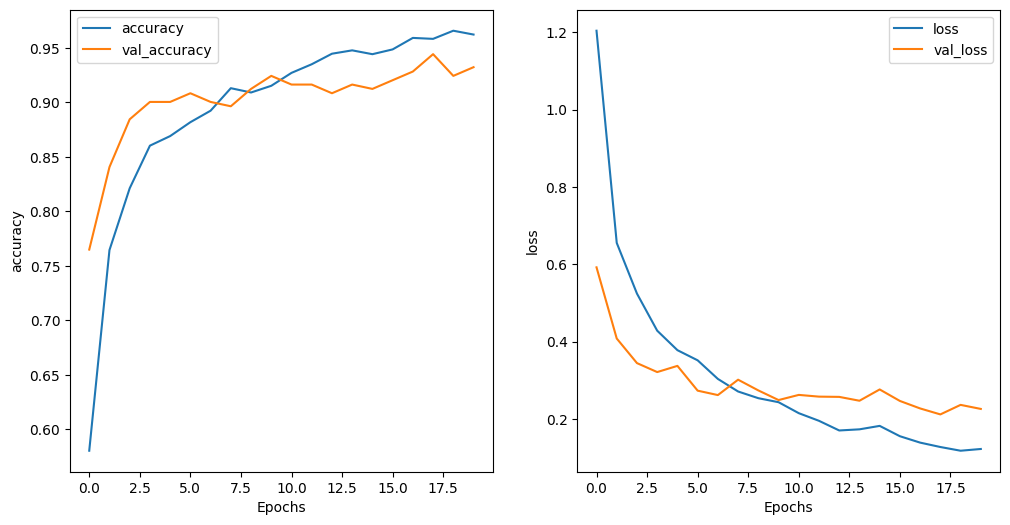

In [14]:
plot_graphs(history=history, strings=['accuracy', 'loss'], filename='/content/graphs/training_history')

In [15]:
model.save('/content/models/4_resnet152_garbage_classification_6_classes_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
with open('/content/models/histories/4_resnet152_garbage_classification_6_classes_model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [17]:
mc = ModelCheckpoint('VGG152 Garbage Classifier.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
loss = history.history['loss']
validation_loss = history.history['val_loss']
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']


base_model.trainable=True
history = model.fit_generator(
   train_batches,
    steps_per_epoch=train_batches.samples/train_batches.batch_size ,
    epochs=10,
    validation_data=valid_batches,
    validation_steps=valid_batches.samples/valid_batches.batch_size,
    verbose=1,
    callbacks = [es, mc],)

loss.extend(history.history['loss'])
validation_loss.extend(history.history['val_loss'])
accuracy.extend(history.history['accuracy'])
validation_accuracy.extend(history.history['val_accuracy'])

<ipython-input-17-687fe0966ab3>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
143/142 [==============================] - ETA: 0s - loss: 0.1121 - accuracy: 0.9649
Epoch 1: val_accuracy improved from -inf to 0.94024, saving model to VGG152 Garbage Classifier.h5
142/142 [==============================] - 42s 293ms/step - loss: 0.1121 - accuracy: 0.9649 - val_loss: 0.2055 - val_accuracy: 0.9402
Epoch 2/10
143/142 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9657
Epoch 2: val_accuracy improved from 0.94024 to 0.94821, saving model to VGG152 Garbage Classifier.h5
142/142 [==============================] - 41s 286ms/step - loss: 0.1118 - accuracy: 0.9657 - val_loss: 0.1786 - val_accuracy: 0.9482
Epoch 3/10
143/142 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.9587
Epoch 3: val_accuracy did not improve from 0.94821
142/142 [==============================] - 40s 281ms/step - loss: 0.1250 - accuracy: 0.9587 - val_loss: 0.1911 - val_accuracy: 0.9402
Epoch 4/10
143/142 [==============================] - ETA: 0

## Display results of training

### Display the training history

In [19]:
history.history['loss'] = loss
history.history['val_loss'] = validation_loss
history.history['accuracy'] = accuracy
history.history['val_accuracy'] = validation_accuracy

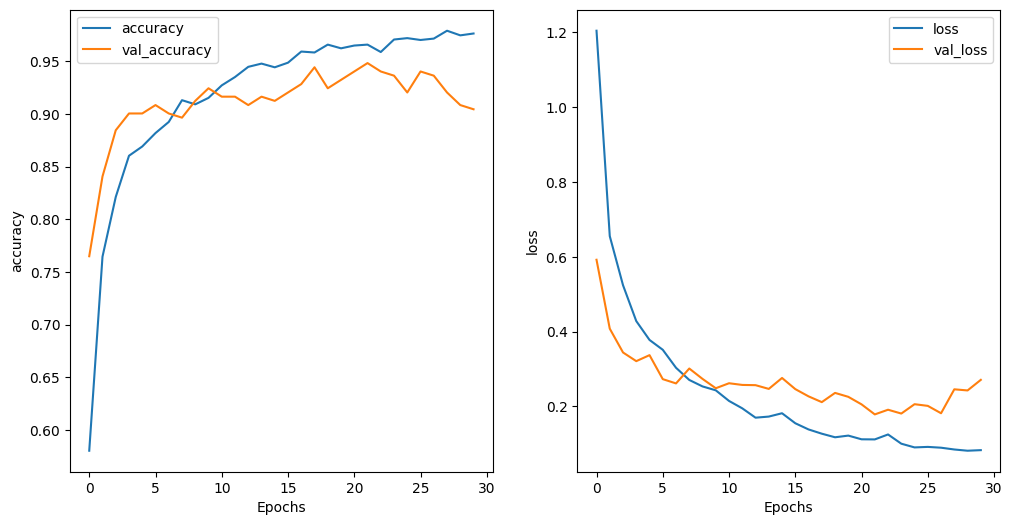

In [20]:
plot_graphs(history=history, strings=['accuracy', 'loss'], filename='/content/graphs/training_history') # , filename='graphs/training_history'

## Evaluate the model

In [54]:
test_dir_path = '/content/garbage_classification_TrainValidTest/test'

# Create an ImageDataGenerator for test data (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=(1./255.))

# Load and preprocess test data using the generator
test_generator = test_datagen.flow_from_directory(directory=test_dir_path,
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  target_size=(300, 300),
                                                  shuffle=False)  # Set shuffle to False to maintain order

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the class labels for the test data
class_labels = list(test_generator.class_indices.keys())

Found 256 images belonging to 6 classes.


In [55]:
class_labels

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
# Generate classification report
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the heatmap
plt.figure(figsize=(8, 6))
# sns.set(font_scale=1.2)  # Adjust font size for better visualization
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/graphs/confusion_matrix.png')
plt.show()

### Save the model

In [21]:
model.save('/content/models/4_1_resnet152_garbage_classification_6_classes_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
with open('/content/models/histories/4_1_resnet152_garbage_classification_6_classes_model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)